In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def prepae_data():
    x, t = [], []
    w = 224
    h = 224

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((w, h))
                img_np = np.array(img_resize) / 255.0
                img_reshape = img_np.reshape(1, w, h, 3)
                #print(datetime.datetime.now().isoformat(), img_np.shape, img_reshape.shape)

                x.append(img_np)
                t.append(category_id)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [37]:
x, t = prepae_data()

2020-06-02T09:56:58.017022 Category 0 : 117
2020-06-02T09:56:58.018724 Image: 0 1015 0
2020-06-02T09:56:58.263567 Image: 30 1228 0
2020-06-02T09:56:58.500113 Image: 60 1106 0
2020-06-02T09:56:58.745483 Image: 90 1129 0
2020-06-02T09:56:58.975515 Category 1 : 119
2020-06-02T09:56:58.976266 Image: 0 3636 1
2020-06-02T09:56:59.211567 Image: 30 3722 1
2020-06-02T09:56:59.452641 Image: 60 3832 1
2020-06-02T09:56:59.689184 Image: 90 3777 1
2020-06-02T09:56:59.923396 Category 2 : 129
2020-06-02T09:56:59.923735 Image: 0 3601 2
2020-06-02T09:57:00.153853 Image: 30 3884 2
2020-06-02T09:57:00.390941 Image: 60 3778 2
2020-06-02T09:57:00.637791 Image: 90 3853 2
2020-06-02T09:57:00.872059 Image: 120 1502 2
2020-06-02T09:57:00.941182 Category 3 : 111
2020-06-02T09:57:00.941840 Image: 0 3312 3
2020-06-02T09:57:01.173831 Image: 30 2350 3
2020-06-02T09:57:01.427002 Image: 60 3010 3
2020-06-02T09:57:01.700147 Image: 90 3105 3


In [38]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(476, 224, 224, 3) (476,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [42]:
print(x_train.shape, x_val.shape)

(333, 224, 224, 3) (143, 224, 224, 3)


In [0]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [43]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications.vgg16 import VGG16

In [0]:
#model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])
#VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model_fine = VGG16(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

In [0]:
reset_seed(0)

for layer in model_fine.layers[:-4]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
#model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.001)
#optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 25088)             0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 25088)             100352    
_________________________________________________________________
dense_56 (Dense)             (None, 50)                1254450   
_________________________________________________________________
dense_57 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_58 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_59 (Dense)             (None, 4)               

In [94]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(x_train, t_train,
                    batch_size=30,
                    epochs=400,
                    verbose=0,
                    validation_data=(x_val, t_val))

print(datetime.datetime.now().isoformat(), 'End')

2020-06-02T10:23:04.591910 Start
2020-06-02T10:32:00.794897 End


In [0]:
results = pd.DataFrame(history.history)

In [97]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
395,0.017062,0.996997,1.911891,0.377622
396,0.018968,0.993994,1.908587,0.384615
397,0.016750,0.996997,1.896580,0.384615
398,0.014781,0.996997,1.889944,0.391608
399,0.014947,0.996997,1.887694,0.384615


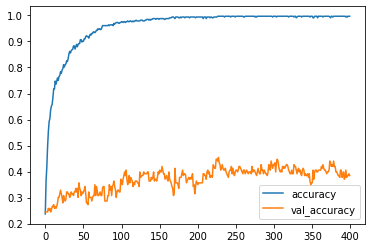

In [98]:
results[['accuracy', 'val_accuracy']].plot()

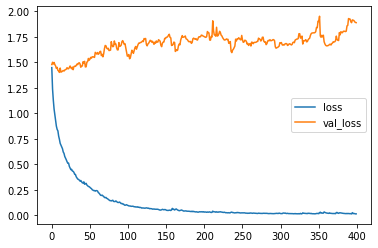

In [99]:
results[['loss', 'val_loss']].plot()